In this notebook you can reproduce the simulation figures to test the PCA denoising algorithm in a 9 fiber phantom with uncorrelated noise.

Let's import the relevant modules for these simulations.

In [1]:
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt
from time import time

from scipy.linalg import eigh
from scipy.ndimage import gaussian_filter

import dipy.reconst.dki as dki
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.data import get_sphere, get_fnames
from dipy.core.gradients import gradient_table
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

<frozen importlib._bootstrap>:219: RuntimeWarning: dipy.direction.pmf.PmfGen size changed, may indicate binary incompatibility. Expected 440 from C header, got 448 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: dipy.direction.pmf.SimplePmfGen size changed, may indicate binary incompatibility. Expected 440 from C header, got 448 from PyObject


The cells below contains the new parts of the code produced for this project, including:

<ins>1) Functions to assess the performance of denoising </ins>

In [2]:
def mp_distribution(x, var, y):
    """ Samples the Marchenko–Pastur probability distribution
    Parameters
    ----------
    x : array (N,)
        Values of random variable to sample the probability distribution
    var : float
        Variance of the random variable
    y : float
        Parameter associated to the matrix X that produces the distributions.
        This X is a M x N random matrix which columns entries are identical
        distributed random variables with mean 0 and given variance, y is given
        by N/M.
    """
    xpos = var * (1 + np.sqrt(y)) ** 2
    xneg = var * (1 - np.sqrt(y)) ** 2

    p = np.zeros(x.shape)
    xdis = np.logical_and(x<xpos, x>xneg)
    p[xdis] = np.sqrt((xpos-x[xdis]) * (x[xdis]-xneg)) / (2*np.pi*var*y*x[xdis])
    if np.sum(p) == 0:
        return p
    else:
        return p / np.sum(p)

    
def _pca_classifier(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    var = np.mean(L)
    c = L.size - 1
    r = L[c] - L[0] - 4 * np.sqrt((L.size) / nvoxels) * var
    while r > 0:
        var = np.mean(L[:c])
        c = c - 1
        sig_mp = (L[c] - L[0]) / (4 * np.sqrt((c + 1.0) / nvoxels)) 
        r =  sig_mp - var
    ncomps = c + 1
    return var, ncomps


def _pca_classifier_slow(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    """
    # To not make any assumptions about the expectation of the
    # number of signal compartments, let's initialize the code
    # assessing all components as being noise (this is the case of
    # background voxels)
    n = L.size
    c = n
    
    # Iterations will stop if the next number of signal components
    # was already assessed in previous iterations. This includes the
    # case c[i] = c[i+1], and also avoids infinite loops, e.g. cases
    # that c[i] = a leads to c[i+1] = b which then leads to c[i+2] = a
    # (i.e. creating a infinite loop of assessing a and b number of
    # components)
    # Given the above, let create a vector to tarked which number of
    # components were assessed.
    c_considered = np.zeros(n)

    # start loop
    # (note c-1 is used instead of c, because c is the number of components,
    # which indexes goes from 0 to c-1)
    while c_considered[c-1] == 0:
        
        # Compute optimal number of bins for the selected noise components

        nbin = np.arange(5, n)  # maximum number of bins is set to number
        # of eigenvalues, i.e. case of a number of bins larger than
        # a number of egienvalues is not considered. 
        # 5 bins are considered as the minumun reasonable 
        # number of bins.

        # procedure implemented according to Veraart et al., 2016 [1]        
        rang = L[c-1] - L[0]
        h = rang / nbin
        nb_vall = np.zeros(nbin.size)
        for ii, ni in enumerate(nbin):
            ro, bins = np.histogram(L[:c], bins=ni, range=(L[0], L[c-1]))
            ro_mean = np.mean(ro)
            ro_var = np.var(ro)
            nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)
        nb = nbin[np.argmin(nb_vall)]

        # compute final histogram to be fitted
        ro, bins = np.histogram(L[:c], bins=nb, range=(L[0], L[c-1]))
            
        # initial variance estimate
        var_in = L[0] / ((1 - np.sqrt(c / nvoxels)) ** 2)
            
        # iteratively refine variance estimate that produces
        # a theoritical distribution that fits the measured histogram
        # (for that let consider a range between half of the initial std
        # estimate and four times larger that the initial std estimate)
        sigma_grid = np.linspace(np.sqrt(var_in)/2, 4*np.sqrt(var_in), num=500)
        sigma_eval = np.zeros(sigma_grid.shape)
        for std_i, std_val in enumerate(sigma_grid):
            dist = c * mp_distribution(bins[:-1]+rang/(2*nb), std_val**2, c / nvoxels)
            notzero = dist > 0
            if np.sum(dist) == 0:
                sigma_eval[std_i] = np.inf
            else:
                sigma_eval[std_i] =  np.sum((ro[notzero] - dist[notzero]) ** 2 / dist[notzero])
        
        indmin = np.flatnonzero(sigma_eval == sigma_eval.min())
        var_out = sigma_grid[indmin[-1]] ** 2
            
        # use refined variance estimate for component classification
        tau_factor = 1 + np.sqrt(c / nvoxels)
        tau = tau_factor ** 2 * var_out
            
        # update number of noise components
        c_considered[c - 1] = 1
        c = np.sum(L < tau)

    ncomps = c
    var = np.mean(L[:c])
    return var, ncomps


def _pca_classifier_slow_plot(L, c, nvoxels, xlim=None):
    """ Plots the fitted MP distribution to the eigenvalue spectrum
    considering the c lower eigenvalues.
    
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    c : int
        number of signal components that you want to consider for
        ploting the MP fitted distribution 
    nvoxels : int
        Number of voxels used to compute L

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        New Number of eigenvalues indicated after histogram fit
    nb : int
        Number of bins automatically determined

    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    """
    n = L.size
    
    # Compute optimal number of bins for the selected noise components

    nbin = np.arange(5, n)  # maximum number of bins is set to number
    # of eigenvalues, i.e. case of a number of bins larger than
    # a number of egienvalues is not considered. 
    # 5 bins are considered as the minumun reasonable 
    # number of bins.

    # procedure implemented according to Veraart et al., 2016 [1]        
    rang = L[c-1] - L[0]
    h = rang / nbin
    nb_vall = np.zeros(nbin.size)
    for ii, ni in enumerate(nbin):
        ro, bins = np.histogram(L[:c], bins=ni, range=(L[0], L[c-1]))
        ro_mean = np.mean(ro)
        ro_var = np.var(ro)
        nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)
    nb = nbin[np.argmin(nb_vall)]

    # compute final histogram to be fitted
    ro, bins = np.histogram(L[:c], bins=nb, range=(L[0], L[c-1]))
            
    # initial variance estimate
    var_in = L[0] / ((1 - np.sqrt((c) / nvoxels)) ** 2)
    
    dist = mp_distribution(bins[:-1]+rang/(2*nb), var_in, c / nvoxels)
    if xlim is None:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.show()
    else:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.xlim(xlim)
        plt.show()
            
    # iteratively refine variance estimate that produces
    # a theoritical distribution that fits the measured histogram
    # (for that let consider a range between half of the initial std
    # estimate and four times larger that the initial std estimate)
    sigma_grid = np.linspace(np.sqrt(var_in)/2, 4*np.sqrt(var_in), num=500)
    sigma_eval = np.zeros(sigma_grid.shape)
    for std_i, std_val in enumerate(sigma_grid):
        dist = c * mp_distribution(bins[:-1]+rang/(2*nb), std_val**2, c / nvoxels)
        notzero = dist > 0
        if np.sum(dist) == 0:
            sigma_eval[std_i] = np.inf
        else:
            sigma_eval[std_i] =  np.sum((ro[dist > 0] - dist[dist > 0]) ** 2 / dist[dist > 0])
            
    plt.figure
    plt.plot(sigma_eval)
    plt.show()
    
    indmin = np.flatnonzero(sigma_eval == sigma_eval.min())
    print(indmin)
    print(indmin[-1])
    var_out = sigma_grid[indmin[-1]] ** 2
    
    dist = mp_distribution(bins[:-1]+rang/(2*nb), var_out, c / nvoxels)
    if xlim is None:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.show()
    else:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.xlim(xlim)
        plt.show()
            
    # use refined variance estimate for component classification
    tau_factor = 1 + np.sqrt(c / nvoxels)
    tau = tau_factor ** 2 * var_out
    cnew = np.sum(L < tau)

    # update number of noise components
    ncomps = cnew
    var = np.mean(L[:cnew])
    return var, ncomps, nb


def _gpca_classifier(L, varest):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. 2023
    """
    var = np.mean(L)
    c = L.size - 1
    while var > varest:
        var = np.mean(L[:c])
        c = c - 1
    ncomps = c + 1
    return var, ncomps


def _tpca_classifier(L, varest, tau_factor):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. 2023
    """
    tau = tau_factor ** 2 * varest
    ncomps = np.sum(L < tau)
    var = np.mean(L[:ncomps])

    return var, ncomps


def _pca_classifier_code(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    rang = np.zeros(L.shape)
    sig2 = np.zeros(L.shape)
    for c in range(1, L.size+1):
        var = np.mean(L[:c])
        c = c - 1
        rang[c] = L[c] - L[0] 
        #sig2[c] =  4 * np.sqrt((c + 1.0) / nvoxels) * var
        sig2[c] =  (L[c] - L[0])/(4 * np.sqrt((L.size) / nvoxels))
        sig2[c] =  (L[c] - L[0])/(4 * np.sqrt((c + 1.0) / nvoxels))
    return var, sig2


def _pca_classifier_code2(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    sig2_w = np.zeros(L.shape)
    sig2_m = np.zeros(L.shape)
    for c in range(1, L.size+1):
        var = np.mean(L[:c])  #RHS
        c = c - 1
        sig2_w[c] = (L[c] - L[0]) / (4 * np.sqrt((c + 1.0) / nvoxels))
        sig2_m[c] = var
    return sig2_m, sig2_w



def _pca_matrix(X, sig2=None, pca_method='eig', mppca_slow=False,
                tau_factor=None):
    """ Helper function to perform PCA-denoising of a 2D matrix

    Parameters
    ----------
    X : 2D array (m, n)
        2D matrix to denoise

    Returns
    -------
    Xd : 2D array (m, n)
        Denoised 2D matrix

    Notes
    -----
    If sigma is None it used MPPCA (standard or slow algorithm if
    to input variable mppca_slow is False or True respectively)
    If sigma and tau_factor is given, it used threshold approach
    If sigma is given but not tau_factor, it uses the TPCA approach
    
    """
    n = X.shape[1]
    m = X.shape[0]
    X0 = X.copy()

    if pca_method.lower() == 'svd':
        is_svd = True
    else:
        is_svd = False
    
    M = np.mean(X0, axis=0)
    X0 = X0 - M

    if is_svd:
        # PCA using an SVD
        U, S, Vt = svd(X0, *svd_args)[:3]
        # Items in S are the eigenvalues, but in ascending order
        # We invert the order (=> descending), square and normalize
        # \lambda_i = s_i^2 / n
        d = S[::-1] ** 2 / X.shape[0]
        # Rows of Vt are eigenvectors, but also in ascending
        # eigenvalue order:
        W = Vt[::-1].T

    else:
        # PCA using an Eigenvalue decomposition
        C = np.transpose(X0).dot(X0)
        C = C / X.shape[0]
        [d, W] = eigh(C, turbo=True)

    if sig2 is None:
        # Random matrix theory
        if mppca_slow:
            this_var, ncomps = _pca_classifier_slow(d, m)
        else:
            this_var, ncomps = _pca_classifier(d, m)
        
    else:
        # Predefined variance
        this_var = sig2
        if tau_factor is None:
            this_var, ncomps = _gpca_classifier(d, this_var)        
        else:
            # tau_factor = 1 + np.sqrt(n / m)
            tau = tau_factor ** 2 * this_var
            
            # Update ncomps according to tau_factor
            ncomps = np.sum(d < tau)
                

    W[:, :ncomps] = 0

    # This is equations 1 and 2 in Manjon 2013:
    Xd = X0.dot(W).dot(W.T) + M

    return Xd, ncomps
                        


<ins> 2) Functions to produce data phantom </ins>

In [3]:
def fib3_phantom_9comps(gtab, snr=None, noise_type='G', N=30):
    """Phantom with three orthogonal fibers"""

    xa = int(1/3 * N)
    
    # sampled 9 directions
    n_pts = 9
    #theta = np.pi * np.random.rand(n_pts)
    #phi = 2 * np.pi * np.random.rand(n_pts)
    #hsph_initial = HemiSphere(theta=theta, phi=phi)
    #hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    #directions = hsph_updated.vertices
    
    directions = np.array([[0.0427, 0.8323, 0.5527],
                           [-0.0328, -0.1969, -0.9799],
                           [0.7303, 0.1161, 0.6732],
                           [-0.0034, 0.5586, -0.8294],
                           [0.9991, -0.0357, -0.0242],
                           [0.0278, 0.9809, -0.1923],
                           [0.7252, 0.6711, -0.1538],
                           [0.6842, -0.1635, -0.7107],
                           [0.6860, -0.7182, 0.1171]])
    
    # define voxel index
    slice_ind = np.zeros((N, N))
    slice_ind[0:xa, 0:xa] = 0
    slice_ind[0:xa, xa:2*xa] = 1
    slice_ind[0:xa, 2*xa:3*xa] = 2
    slice_ind[xa:2*xa, 0:xa] = 3
    slice_ind[xa:2*xa, xa:2*xa] = 4
    slice_ind[xa:2*xa, 2*xa:3*xa] = 5
    slice_ind[2*xa:3*xa, 0:xa] = 6
    slice_ind[2*xa:3*xa, xa:2*xa] = 7
    slice_ind[2*xa:3*xa, 2*xa:3*xa] = 8

    # Define tisse diffusion parameters
    # Restricted diffusion
    ADr = 1.8e-3
    RDr = 0.0
    # Hindered diffusion
    ADh = 1.5e-3
    RDh = 0.5e-3

    # Fraction between Restricted and Hindered diffusion (in index order)
    f = np.array([0.3, 0.35, 0.4,
                  0.6, 0.65, 0.7,
                  0.45, 0.5, 0.55])

    # produce signals according to multi-tensor code
    axyz = directions
    DWI = np.zeros((N, N, gtab.bvals.size))
    for vi in range(9):
        if vi > 2 and vi < 6:
            fractions = [f[vi]*50, (1-f[vi])*50,
                         f[vi-3]*50, (1-f[vi-3])*50]
            angles = [axyz[vi], axyz[vi],
                      axyz[vi-3], axyz[vi-3]]
            mevals = np.array([[ADr, RDr, RDr], [ADh, RDh, RDh],
                               [ADr, RDr, RDr], [ADh, RDh, RDh]])
        else:
            fractions = [f[vi]*100, (1-f[vi])*100]
            angles = [axyz[vi], axyz[vi]]
            mevals = np.array([[ADr, RDr, RDr], [ADh, RDh, RDh]])
        sig, direction = multi_tensor(gtab, mevals, angles=angles,
                                      fractions=fractions, snr=None)
        DWI[slice_ind == vi, :] = sig
        #print([axyz[vi], axyz[vi]])

    if snr is None:
        return DWI
    else:
        noise_adder = {'gaussian': _add_gaussian,
                       'rician': _add_rician,
                       'rayleigh': _add_rayleigh}
        
        sigma = 1.0 /snr
        n1 = np.random.normal(0, sigma, size=DWI.shape)
        if noise_type == 'gaussian':
            n2 = None
        else:
            n2 = np.random.normal(0, sigma, size=DWI.shape)

        return noise_adder[noise_type](DWI, n1, n2)

<ins> 3) Functions to corrupt phantom with spatially uncorrelated noise </ins>

In [4]:
def add_noise_phantom(Phantom, snr=None, noise_type='gaussian'):
    if snr is None:
        return Phantom
    else:
        S1 = 1

        noise_adder = {'gaussian': _add_gaussian,
                       'rician': _add_rician,
                       'rayleigh': _add_rayleigh}
        
        sigma = S1 * 1.0 /snr
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        if noise_type == 'gaussian':
            n2 = None
        else:
            n2 = np.random.normal(0, sigma, size=Phantom.shape)

        return noise_adder[noise_type](Phantom, n1, n2)   

<ins> 4) Functions to add spatial correlations </ins>

In [5]:
def smooth(data, gauss_std):
    data_smooth = np.zeros(data.shape)
    for v in range(data.shape[-1]):
        data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)
    return data_smooth

def zero_fill(dwi, nz):
    nvol = dwi.shape
    nvo = nvol[2]
    for jj in range(nvo):
        c = np.fft.fft2(dwi[:, :, jj])
        c = np.fft.fftshift(c)
        # if you want to add zero filling in all image boundaries
        # you can uncomment lines of code below
        #c[:, :nz] = 0
        c[(-nz-1):, :] = 0 
        # c[:nz, :] = 0
        #c[:, (-nz-1):] = 0 
        dwi[:, :, jj] = abs(np.fft.ifft2(c))
    return dwi

# Simulation settings

In the cell below you can change the settings of different parameters of the simulations. Example you can change: 1) the simulations SNR of the initial raw data; 2) method two generated spatiaaly correlated noise (if corrupt == 1 spatially correlated noise is generated by smoothing the noisy and ground truth data, if corrupt == 2 spatially correlated noise is generated by zero-filling the noisy and ground truth data)

In [6]:
snr = 30
N = 12  # dimension of the phantom will be NxN

# If gaussian==false, Rician noise is used
gaussian = True

# corrupt 1 noise is spatial correlated by adding smoothing to noise corrupted phantoms
# corrupt 2 noise is spatial correlated by adding zero filling
corrupt = 2
zf = int(N/4)  # number of voxels for zero-filling corruption 
gauss_std = 0.6 # std of Gaussian kernel for gaussian noise corruption

Initialize seed so that random instances are reproducible when reruning the notebook again.
If you are interested in assessing the generality of the results for other noise instances, you can just ignore this command line.

In [7]:
np.random.seed(10)

# Simulate acquisition parameters

Signals are generated for 110 different sets of single diffusion encoding (SDE), comprising 20 b-value=0 experiments and 30 gradient directions for b-values 1000, 2000, and 3000 s/mm2

In [8]:
# Sample the spherical cordinates of 30 evenly distributed
# diffusion-weighted directions
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
V = hsph_updated.vertices

# Reconstruct acquisition parameters for 20 b0s and 45 directions for b=1000 and 2000
bvals = np.hstack((np.zeros(20), 1000 * np.ones(n_pts), 2000 * np.ones(n_pts), 3000 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((20, 3)), V, V, V))

# Generate a object containing the information of b-values and gradient directions
# (using the same format used in Dipy)
gtab = gradient_table(bvals, bvecs)

### Ground truth Phantom

Let first generate ground truth phantoms

In [9]:
# Ground truth for uncorrelated noise
DWI = fib3_phantom_9comps(gtab, N=N)

# Ground truth for correlated noise
if corrupt == 1:
    DWIc = smooth(DWI.copy(), gauss_std)
else:
    DWIc = zero_fill(DWI.copy(), zf)

m = DWI.shape[0] * DWI.shape[1]
n = DWI.shape[-1]

Generate 1000 instances of phantom simulations to assess the performance of noise estimates as a function of number of b0 repetitions

In [10]:
def _helper_l_gen(DWI, snr, gaussian=True, corrupt=1, gauss_std=0.6, zf=2):
    if gaussian:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
    else:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')

    if corrupt == 1:
        DWInc = smooth(DWIn, gauss_std)
    elif corrupt == 2:
        DWInc = zero_fill(DWIn.copy(), zf)
    else:
        DWInc = DWIn.copy()
    
    n = DWInc.shape[-1]
    m = DWInc.shape[0]*DWIn.shape[1]
    X = DWInc.reshape(m, n)
    M = np.mean(X, axis=0)
    X = X - M
    [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
    return L

In [11]:
nb0s = np.arange(2, 21)
print(nb0s)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [12]:
# spatially uncorrelated noise

nrep = 1000
var_estimate = np.zeros((nrep, nb0s.size))

n_mpca = np.zeros(nrep)

n_tpca_2 = np.zeros(nrep)
n_gpca_2 = np.zeros(nrep)

n_tpca_5 = np.zeros(nrep)
n_gpca_5 = np.zeros(nrep)

n_tpca_10 = np.zeros(nrep)
n_gpca_10 = np.zeros(nrep)

n_tpca_20 = np.zeros(nrep)
n_gpca_20 = np.zeros(nrep)

for rep in range(nrep):
    if gaussian:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
    else:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')
    
    #if corrupt == 1:
    #    DWIn = smooth(DWIn.copy(), gauss_std)
    for nb0 in range(nb0s.size):
        var_estimate[rep, nb0] = np.mean(np.var(DWIn[..., :nb0s[nb0]], axis=-1, ddof=1))

    X = DWIn.reshape(m, n)
    M = np.mean(X, axis=0)
    X = X - M
    [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
    
    var_mpca, n_mpca_i =  _pca_classifier(L.copy(), m)
    
    n_mpca[rep] = n_mpca_i

    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_estimate[rep, 0])
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_estimate[rep, 0], tau_factor=1+np.sqrt(n / m))

    n_gpca_2[rep] = ncomp_gpca
    n_tpca_2[rep] = ncomp_tpca

    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_estimate[rep, 3])
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_estimate[rep, 3], tau_factor=1+np.sqrt(n / m))

    n_gpca_5[rep] = ncomp_gpca
    n_tpca_5[rep] = ncomp_tpca
    
    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_estimate[rep, 8])
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_estimate[rep, 8], tau_factor=1+np.sqrt(n / m))

    n_gpca_10[rep] = ncomp_gpca
    n_tpca_10[rep] = ncomp_tpca
    
    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_estimate[rep, -1])
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_estimate[rep, -1], tau_factor=1+np.sqrt(n / m))

    n_gpca_20[rep] = ncomp_gpca
    n_tpca_20[rep] = ncomp_tpca
    
    print(rep)

median_p = np.zeros((nb0s.size)) 
lower_p = np.zeros((nb0s.size)) 
upper_p = np.zeros((nb0s.size)) 

for nb0 in range(nb0s.size):
    p25, p50, p75 = np.percentile(var_estimate[:, nb0], [25, 50, 75])
    median_p[nb0] = p50
    lower_p[nb0] = p50 - p25 
    upper_p[nb0] = p75 - p50

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

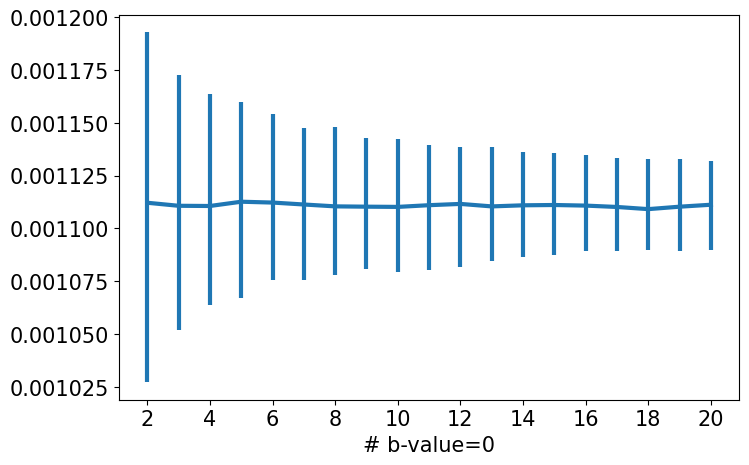

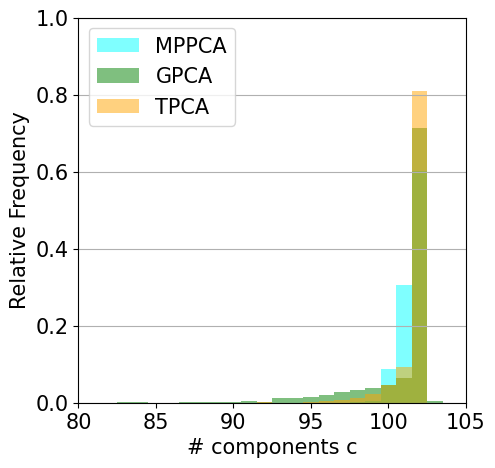

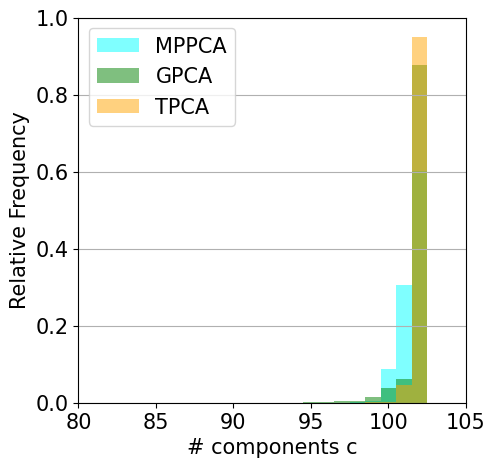

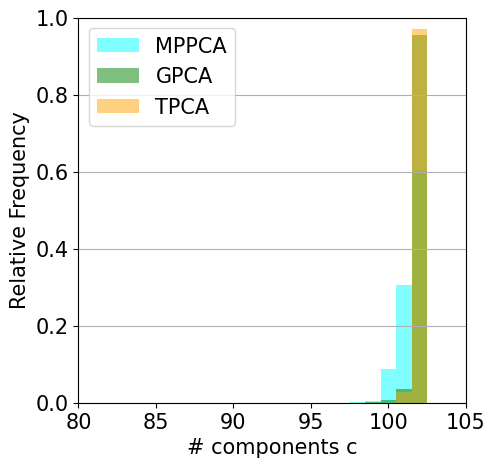

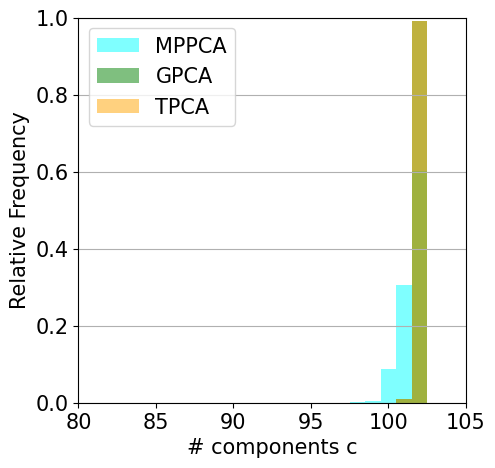

In [13]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(8, 5))
plt.errorbar(nb0s, median_p, yerr=[lower_p, upper_p], linewidth=3.0)
ax.set_xticks(np.arange(2, 21, 2))
plt.xlabel('# b-value=0')

fig = plt.figure(figsize=(5, 5))

bins = np.arange(0, 110, 1) - 0.5
nnn, bins, patches = plt.hist(x=n_mpca, bins=bins, color='cyan', label='MPPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_mpca) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_gpca_2, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_tpca_2, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)

plt.grid(axis='y', alpha=1)
plt.xlim([80, 105])
plt.ylim([0, 1])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()

plt.legend(loc=0, prop={'size': 15})

fig = plt.figure(figsize=(5, 5))

bins = np.arange(0, 110, 1) - 0.5

nnn, bins, patches = plt.hist(x=n_mpca, bins=bins, color='cyan', label='MPPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_mpca) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_gpca_5, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_tpca_5, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)

plt.grid(axis='y', alpha=1)
plt.xlim([80, 105])
plt.ylim([0, 1])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()

plt.legend(loc=0, prop={'size': 15})


fig = plt.figure(figsize=(5, 5))

bins = np.arange(0, 110, 1) - 0.5

nnn, bins, patches = plt.hist(x=n_mpca, bins=bins, color='cyan', label='MPPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_mpca) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_gpca_10, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_tpca_10, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)

plt.grid(axis='y', alpha=1)
plt.xlim([80, 105])
plt.ylim([0, 1])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()

plt.legend(loc=0, prop={'size': 15})


fig = plt.figure(figsize=(5, 5))

bins = np.arange(0, 110, 1) - 0.5

nnn, bins, patches = plt.hist(x=n_mpca, bins=bins, color='cyan', label='MPPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_mpca) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_gpca_20, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_tpca_20, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)

plt.grid(axis='y', alpha=1)
plt.xlim([80, 105])
plt.ylim([0, 1])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()

plt.legend(loc=0, prop={'size': 15})


plt.rcParams.update({'font.size': 10})

In [14]:
# spatially correlated noise

nrep = 1000
var_estimate = np.zeros((nrep, nb0s.size))

n_mpca = np.zeros(nrep)

n_tpca_2 = np.zeros(nrep)
n_gpca_2 = np.zeros(nrep)

n_tpca_5 = np.zeros(nrep)
n_gpca_5 = np.zeros(nrep)

n_tpca_10 = np.zeros(nrep)
n_gpca_10 = np.zeros(nrep)

n_tpca_20 = np.zeros(nrep)
n_gpca_20 = np.zeros(nrep)

for rep in range(nrep):
    if gaussian:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
    else:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')
    
    if corrupt == 1:
        DWIn = smooth(DWIn.copy(), gauss_std)
    else:
        DWIn = zero_fill(DWIn.copy(), zf)
    
    for nb0 in range(nb0s.size):
        var_estimate[rep, nb0] = np.mean(np.var(DWIn[..., :nb0s[nb0]], axis=-1, ddof=1))

    X = DWIn.reshape(m, n)
    M = np.mean(X, axis=0)
    X = X - M
    [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
    
    var_mpca, n_mpca_i =  _pca_classifier(L.copy(), m)
    
    n_mpca[rep] = n_mpca_i

    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_estimate[rep, 0])
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_estimate[rep, 0], tau_factor=1+np.sqrt(n / m))

    n_gpca_2[rep] = ncomp_gpca
    n_tpca_2[rep] = ncomp_tpca

    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_estimate[rep, 3])
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_estimate[rep, 3], tau_factor=1+np.sqrt(n / m))

    n_gpca_5[rep] = ncomp_gpca
    n_tpca_5[rep] = ncomp_tpca
    
    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_estimate[rep, 8])
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_estimate[rep, 8], tau_factor=1+np.sqrt(n / m))

    n_gpca_10[rep] = ncomp_gpca
    n_tpca_10[rep] = ncomp_tpca
    
    var_gpca, ncomp_gpca = _gpca_classifier(L.copy(), var_estimate[rep, -1])
    var_tpca, ncomp_tpca = _tpca_classifier(L.copy(), var_estimate[rep, -1], tau_factor=1+np.sqrt(n / m))

    n_gpca_20[rep] = ncomp_gpca
    n_tpca_20[rep] = ncomp_tpca
    
    print(rep)

median_p = np.zeros((nb0s.size)) 
lower_p = np.zeros((nb0s.size)) 
upper_p = np.zeros((nb0s.size)) 

for nb0 in range(nb0s.size):
    p25, p50, p75 = np.percentile(var_estimate[:, nb0], [25, 50, 75])
    median_p[nb0] = p50
    lower_p[nb0] = p50 - p25 
    upper_p[nb0] = p75 - p50

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

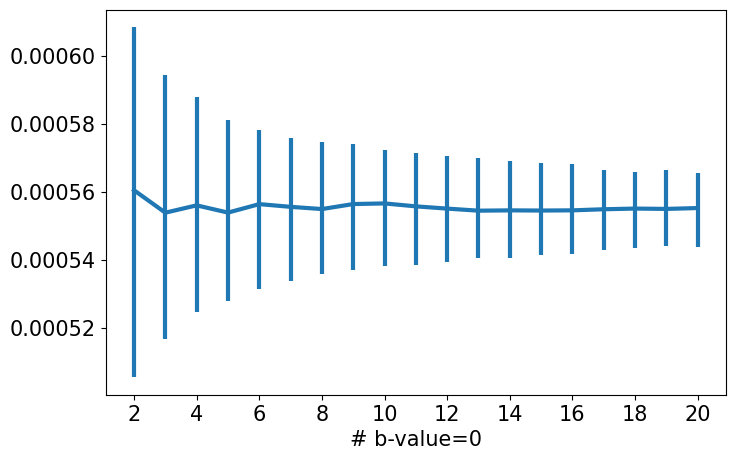

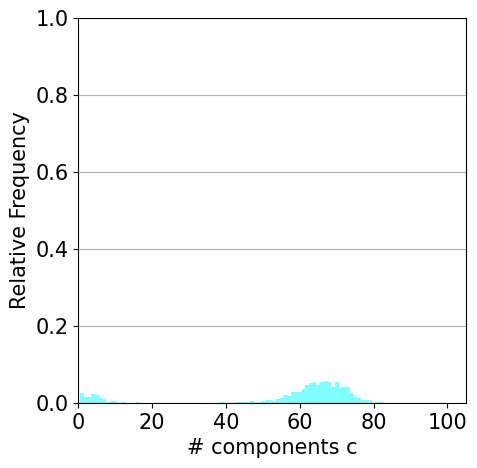

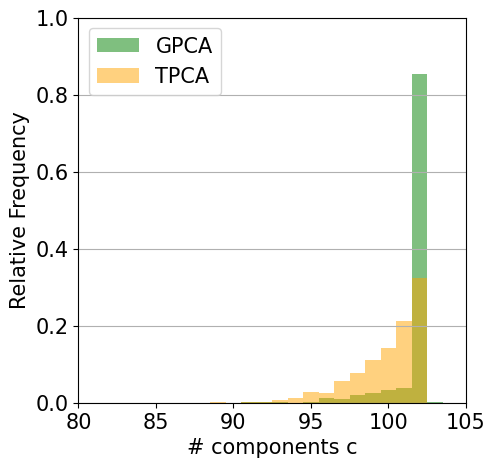

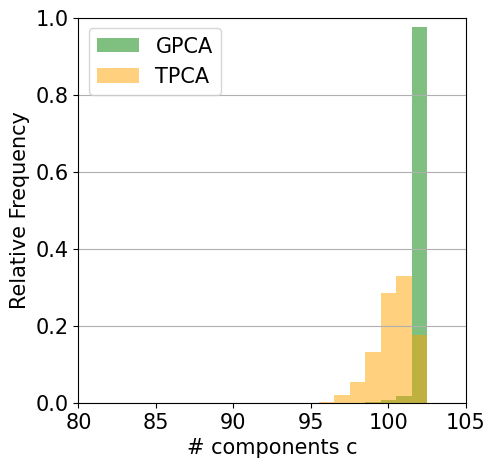

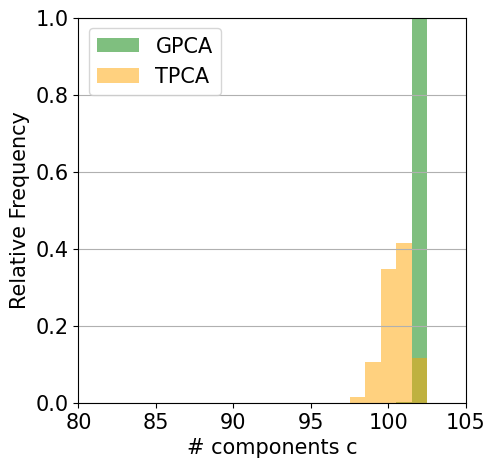

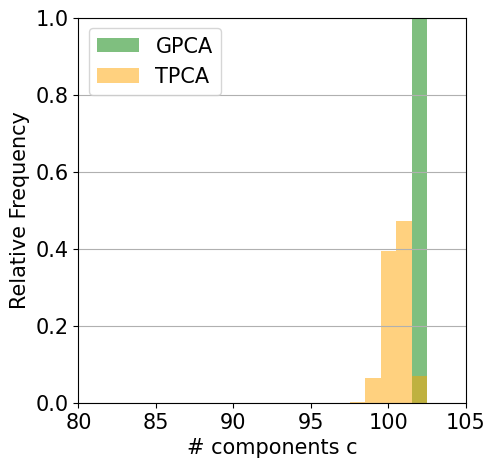

In [15]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(8, 5))
plt.errorbar(nb0s, median_p, yerr=[lower_p, upper_p], linewidth=3.0)
ax.set_xticks(np.arange(2, 21, 2))
plt.xlabel('# b-value=0')


fig = plt.figure(figsize=(5, 5))

bins = np.arange(0, 110, 1) - 0.5

nnn, bins, patches = plt.hist(x=n_mpca, bins=bins, color='cyan', label='MPPCA',
                             alpha=0.5, rwidth=1, weights=np.zeros_like(n_mpca) + 1. / 1000)
#nnn, bins, patches = plt.hist(x=n_gpca_2, bins=bins, color='green', label='GPCA',
#                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
#nnn, bins, patches = plt.hist(x=n_tpca_2, bins=bins, color='orange', label='TPCA',
#                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
plt.grid(axis='y', alpha=1)
plt.xlim([0, 105])
plt.ylim([0, 1])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()


fig = plt.figure(figsize=(5, 5))

bins = np.arange(0, 110, 1) - 0.5

#nnn, bins, patches = plt.hist(x=n_mpca, bins=bins, color='cyan', label='MPPCA',
#                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_mpca) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_gpca_2, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_tpca_2, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)

plt.grid(axis='y', alpha=1)
plt.xlim([80, 105])
plt.ylim([0, 1])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()

plt.legend(loc=0, prop={'size': 15})


fig = plt.figure(figsize=(5, 5))

bins = np.arange(0, 110, 1) - 0.5

#nnn, bins, patches = plt.hist(x=n_mpca, bins=bins, color='cyan', label='MPPCA',
#                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_mpca) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_gpca_5, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_tpca_5, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)

plt.grid(axis='y', alpha=1)
plt.xlim([80, 105])
plt.ylim([0, 1])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()

plt.legend(loc=0, prop={'size': 15})


fig = plt.figure(figsize=(5, 5))

bins = np.arange(0, 110, 1) - 0.5

#nnn, bins, patches = plt.hist(x=n_mpca, bins=bins, color='cyan', label='MPPCA',
#                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_mpca) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_gpca_10, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_tpca_10, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)

plt.grid(axis='y', alpha=1)
plt.xlim([80, 105])
plt.ylim([0, 1])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()

plt.legend(loc=0, prop={'size': 15})


fig = plt.figure(figsize=(5, 5))

bins = np.arange(0, 110, 1) - 0.5

#nnn, bins, patches = plt.hist(x=n_mpca, bins=bins, color='cyan', label='MPPCA',
#                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_mpca) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_gpca_20, bins=bins, color='green', label='GPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)
nnn, bins, patches = plt.hist(x=n_tpca_20, bins=bins, color='orange', label='TPCA',
                              alpha=0.5, rwidth=1, weights=np.zeros_like(n_tpca_2) + 1. / 1000)

plt.grid(axis='y', alpha=1)
plt.xlim([80, 105])
plt.ylim([0, 1])
plt.xlabel('# components c')
plt.ylabel('Relative Frequency')
maxfreq = nnn.max()

plt.legend(loc=0, prop={'size': 15})

plt.rcParams.update({'font.size': 10})